### Librerias

In [1]:
import os
from pathlib import Path
import sys
import re

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim
import torchmetrics

import pytorch_lightning as pl
import lightning as L
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np
import pandas as pd

### Carga de Informacion

In [2]:
main_path = Path(os.getcwd())
data_path = main_path / "data" / "final"/ "ted_speech_clean.csv"

if not data_path.exists():
    raise FileNotFoundError(f"File not found: {data_path}")

## Creacion del CustomDataset

In [3]:
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk

In [4]:
class TextDataset(Dataset):
    def __init__(self, data_path, sequence_length=50, limit=None, vocab_size=10000):
        if limit:
            self.data = pd.read_csv(data_path).head(limit)
        else:
            self.data = pd.read_csv(data_path)
        
        self.sequence_length = sequence_length

        # Preprocesar texto
        all_text = ' '.join(self.data['transcript']).lower()

        # Tokenizar por palabras
        words = nltk.word_tokenize(all_text)
        
        # Construir vocabulario
        word_counts = Counter(words)
        self.vocab = ['<PAD>', '<UNK>'] + [word for word, _ in word_counts.most_common(vocab_size - 2)]
        self.token_to_idx = {token: idx for idx, token in enumerate(self.vocab)}
        self.idx_to_token = {idx: token for token, idx in self.token_to_idx.items()}

        # Función de tokenización
        self.tokenize = lambda x: [self.token_to_idx.get(word, self.token_to_idx['<UNK>']) for word in word_tokenize(x.lower())]

        # Codificar discursos
        self.encoded_speeches = [self.tokenize(speech) for speech in self.data['transcript']]

        # Crear secuencias
        self.sequences = []
        for encoded_speech in self.encoded_speeches:
            for i in range(0, len(encoded_speech) - sequence_length):
                self.sequences.append(encoded_speech[i:i+sequence_length+1])  # +1 para incluir la palabra objetivo
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        return torch.tensor(sequence[:-1]), torch.tensor(sequence[1:])

## Creacion del Custom DataLoader

In [5]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
import torch

class TextDataModule(pl.LightningDataModule):
    def __init__(self, data_path, batch_size=32, sequence_length=128, limit=None, 
                 vocab_size=10000, val_split=0.1, test_split=0.1, num_workers=4):
        super().__init__()
        self.data_path = data_path
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.limit = limit
        self.vocab_size = vocab_size
        self.val_split = val_split
        self.test_split = test_split
        self.num_workers = num_workers
    
    def setup(self, stage=None):
        # Crear el dataset completo
        full_dataset = TextDataset(
            self.data_path,
            sequence_length=self.sequence_length,
            limit=self.limit,
            vocab_size=self.vocab_size
        )
        
        # Calcular tamaños de los splits
        dataset_size = len(full_dataset)
        val_size = int(dataset_size * self.val_split)
        test_size = int(dataset_size * self.test_split)
        train_size = dataset_size - val_size - test_size
        
        # Dividir el dataset
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_size, val_size, test_size],
            generator=torch.Generator().manual_seed(42)  # Para reproducibilidad
        )
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, 
            batch_size=self.batch_size, 
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, 
            batch_size=self.batch_size, 
            shuffle=False, 
            num_workers=self.num_workers,
            pin_memory=True
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, 
            batch_size=self.batch_size, 
            shuffle=False, 
            num_workers=self.num_workers,
            pin_memory=True
        )
    
    def get_vocab_size(self):
        return len(self.train_dataset.dataset.vocab)

In [6]:
# Ejemplo de uso

data_module = TextDataModule(data_path, batch_size=32, sequence_length=128, limit=1,num_workers=0)

# Preparar los datos
data_module.setup()

# Verificar el DataLoader
for batch in data_module.train_dataloader():
    sequences, targets = batch
    print(sequences)
    print(targets)
    break


tensor([[  4,  43,  11,  ..., 329, 330,  66],
        [ 49,  79,   2,  ...,  82,   5,  96],
        [171,   4,  11,  ..., 128,  48, 309],
        ...,
        [ 45,   6,   8,  ...,   3,  12,  26],
        [149,  31,  15,  ..., 124, 443, 192],
        [ 26,  91,  59,  ...,  94,  22,   5]])
tensor([[ 43,  11, 110,  ..., 330,  66,  27],
        [ 79,   2,  36,  ...,   5,  96,  35],
        [  4,  11,   9,  ...,  48, 309, 310],
        ...,
        [  6,   8, 273,  ...,  12,  26,  29],
        [ 31,  15, 408,  ..., 443, 192, 444],
        [ 91,  59,  29,  ...,  22,   5,   2]])


### creacion de la LSTM

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torchmetrics

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=1):
        super(LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        return self.fc(output)

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))


In [8]:
class LSTMNextWordPredictor(pl.LightningModule):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=1, learning_rate=0.001):
        super().__init__()
        self.learning_rate = learning_rate
        self.vocab_size = vocab_size
        self.model = LSTM(vocab_size, embedding_dim, hidden_size, num_layers)

        # Guardar hiperparámetros en directorio de logs
        self.save_hyperparameters(ignore=["model"])

        # Definición de métricas
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=vocab_size)
        self.valid_acc = torchmetrics.Accuracy(task='multiclass', num_classes=vocab_size)
        self.test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=vocab_size)

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        sequences, targets = batch
        logits = self(sequences)
        
        # Reshape logits to (batch_size * sequence_length, vocab_size)
        logits = logits.view(-1, self.vocab_size)
        
        # Reshape targets to (batch_size * sequence_length)
        targets = targets.view(-1)
        
        # Now both should have compatible shapes
        loss = F.cross_entropy(logits, targets)
        predicted_words = torch.argmax(logits, dim=-1)
        
        return loss, targets, predicted_words

    def training_step(self, batch, batch_idx):
        loss, targets, predicted_words = self._shared_step(batch)
        self.log("train_loss", loss, on_epoch=True, on_step=False, prog_bar=True)
        self.train_acc(predicted_words.view(-1), targets.view(-1))
        self.log("train_acc", self.train_acc, on_epoch=True, on_step=False, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, targets, predicted_words = self._shared_step(batch)
        self.log("val_loss", loss, on_epoch=True, on_step=False, prog_bar=True)
        self.valid_acc(predicted_words.view(-1), targets.view(-1))
        self.log("valid_acc", self.valid_acc, on_epoch=True, on_step=False, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, targets, predicted_words = self._shared_step(batch)
        self.log("test_loss", loss, on_epoch=True, on_step=False, prog_bar=True)
        self.test_acc(predicted_words.view(-1), targets.view(-1))
        self.log("test_acc", self.test_acc, on_epoch=True, on_step=False, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    
    def set_vocab(self, token_to_idx, idx_to_token):
        self.token_to_idx = token_to_idx
        self.idx_to_token = idx_to_token

## entrenamiento del modelo

In [9]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger

# Hiperparámetros
NUM_EPOCHS = 60
BATCH_SIZE = 16
LEARNING_RATE = 0.0001
HIDDEN_SIZE = 256
EMBEDDING_DIM = 200
NUM_LAYERS = 2
LIMIT = 250
NUM_WORKERS = 31
# Crear el DataModule
data_module = TextDataModule(
    data_path=data_path,
    batch_size=BATCH_SIZE,
    sequence_length=20,  # Ajusta según tus necesidades
    vocab_size=10000,     # Ajusta según tus necesidades
    limit=LIMIT,           # Ajusta según tus necesidades
    num_workers = NUM_WORKERS
)

# Configurar el DataModule
data_module.setup()

# Obtener el tamaño del vocabulario
vocab_size = data_module.get_vocab_size()

# Crear el modelo
lstm_model = LSTMNextWordPredictor(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    learning_rate=LEARNING_RATE
)

# Callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='lstm-next-word-{epoch:02d}-{val_loss:.2f}',
    save_top_k=2,
    monitor='val_loss',
    mode='min'
)

progress_bar = TQDMProgressBar(refresh_rate=10)

# Logger
logger = CSVLogger(save_dir="logs/", name="lstm_next_word_predictor")

# Trainer
trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    callbacks=[checkpoint_callback, progress_bar],
    accelerator="auto",  # Usa GPUs o TPUs si están disponibles
    devices="auto",      # Usa todos los GPUs/TPUs disponibles si es aplicable
    logger=logger,
    deterministic=False,
    log_every_n_steps=10
)

# Entrenamiento
trainer.fit(lstm_model, datamodule=data_module)

# Guardar el modelo
trainer.save_checkpoint("lstm_next_word_final_model.ckpt")

# Evaluación en el conjunto de prueba
test_result = trainer.test(lstm_model, datamodule=data_module)
print(f"Resultado del test: {test_result}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /teamspace/studios/this_studio/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | LSTM               | 5.6 M  | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | valid_acc | MulticlassAccuracy | 0      | train
3 | test_acc  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=60` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7079901099205017     │
│         test_loss         │    1.4562623500823975     │
└───────────────────────────┴───────────────────────────┘

Resultado del test: [{'test_loss': 1.4562623500823975, 'test_acc': 0.7079901099205017}]


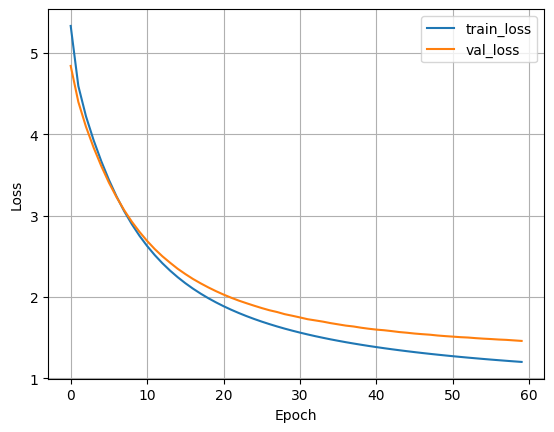

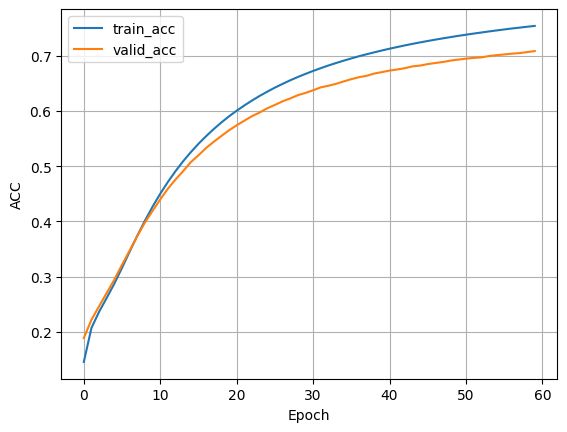

In [10]:
# graficar la perdida
import pandas as pd
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss","val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_acc", "valid_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.show()

In [11]:
# Cargar el modelo
model = LSTMNextWordPredictor.load_from_checkpoint("lstm_next_word_final_model.ckpt")
model.eval()


dataset = TextDataset(
    data_path=data_path,
    sequence_length=20,  
    vocab_size=10000,
         limit=LIMIT
)

print(model.vocab_size)
# Establecer el vocabulario en el modelo
model.set_vocab(dataset.token_to_idx, dataset.idx_to_token)

# Verificar que el vocabulario se ha establecido correctamente
print("Tamaño del vocabulario:", len(model.token_to_idx))



10000
Tamaño del vocabulario: 10000


In [14]:
# Función para generar texto
import random
random_seed = random.randint(0, 1000)
torch.manual_seed(random_seed)

def generate_text(model, start_sequence, max_length=2):
    model.eval()
    current_sequence = start_sequence
    generated_sequence = start_sequence.copy()

    for _ in range(max_length):
        with torch.no_grad():
            input_tensor = torch.tensor([current_sequence]).to(model.device)
            output = model(input_tensor)
            next_word_idx = output[0, -1, :].argmax().item()
        
        generated_sequence.append(next_word_idx)
        current_sequence = current_sequence[1:] + [next_word_idx]

    return generated_sequence

# Usar el modelo para predecir
sequence="Space exploration will revolutionize our understanding of"
start_sequence = [model.token_to_idx.get(word.lower(), model.token_to_idx['<UNK>']) for word in sequence.split()]
print(start_sequence)
# Generar texto
generated_indices = generate_text(model, start_sequence)

# Convertir índices a palabras
generated_text = [model.idx_to_token[idx] for idx in generated_indices]

print(" ".join(generated_text))

[217, 2934, 85, 5612, 45, 585, 7]
space exploration will revolutionize our understanding of the next
